In [ ]:
%%sql


Fetch average queue times by week using panda.  Imports first.

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf


import tensorflow as tf


Establish connection to cedar point database for sqllite

In [2]:
conn = sqlite3.connect('../../../cp.db')

Establish connection to postgres in aws

In [1]:
import psycopg2

def get_db_connection():
    try:
        conn = psycopg2.connect(
            host='cp-ai.cbsscwgeqp5j.us-east-2.rds.amazonaws.com',
            port=5432,
            database='postgres',
            user='postgres',
            password='CedarP0int'
        )
        return conn
    except psycopg2.Error as e:
        print(f"Error connecting to PostgreSQL database: {e}")
        return None

# Example usage:
conn = get_db_connection()


In [4]:
df = pd.read_sql("SELECT * FROM crowd_levels", conn)
conn.close()

C:\Users\rober\AppData\Local\Temp\ipykernel_33904\662286218.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM crowd_levels", conn)


In [5]:
df.head()               # Preview first few rows
df["crowd_level"].mean()  # Compute average wait time

np.float64(19.290514421647337)

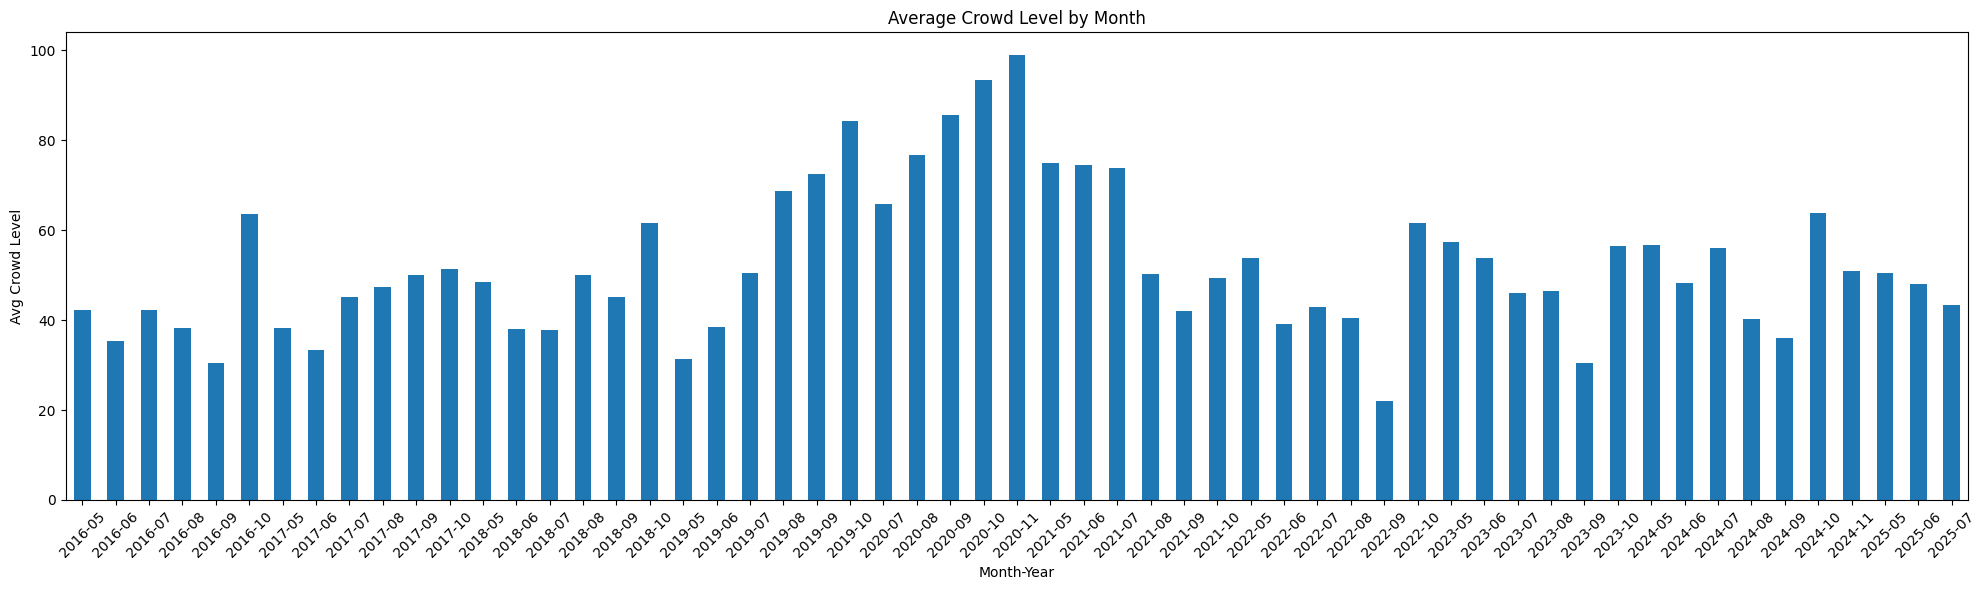

In [16]:
df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
df["year_week"] = df["year"].astype(str) + "-" + df["season_week"].astype(str).str.zfill(2)

monthly_avg = df[df["is_open"] == 'Y'].groupby("year_month")["crowd_level"].mean()
monthly_avg = monthly_avg.sort_index()  # This sorts by year_month
monthly_avg.plot(kind="bar", title="Average Crowd Level by Month", figsize=(20, 6))
plt.xlabel("Month-Year")
plt.ylabel("Avg Crowd Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:

print(df.columns)

Index(['date', 'crowd_level', 'year', 'day_of_week', 'is_open',
       'forecast_temp', 'actual_temp', 'forecast_wind', 'actual_wind',
       'forecast_rain', 'actual_rain', 'special_day_halloweekends',
       'special_day_military_days', 'special_day_light_up_the_point',
       'special_day_coaster_mania', 'special_day_opening_day',
       'special_day_boardwalk_nights', 'special_day_fathers_day',
       'special_day_mothers_day', 'special_day_fourth_of_july',
       'special_day_memorial_day', 'special_day_labor_day',
       'special_day_last_day_of_year', 'covid_19_day', 'reload_row', 'month',
       'cedar_point_week', 'school_day', 'year_month', 'year_week'],
      dtype='object')


Below grabs the features of interest and removes one that has a null for the actual temp.

In [27]:
park_features = df[(df['is_open'] == 'Y') &(df['covid_19_day'] == 'N') & df["actual_temp"].notnull() & df["actual_rain"].notnull()][[
    "day_of_week",
    "actual_temp",
    "actual_rain",
    "month",
    "season_week",
    "school_season",
    "hallowweekend",
    "coaster_mania",
    "opening_day",
    "fathers_day",
    "mothers_day",
    "fourth_of_july",
    "crowd_level"
]]
crowd_levels = park_features["crowd_level"]

def categorize_crowd_level(pct):
    if pct < 25:
        return 0  # Low
    elif pct < 50:
        return 1  # Medium
    elif pct < 75:
        return 2  # High
    else:
        return 3  # Very High

crowd_categories = crowd_levels.apply(categorize_crowd_level).rename("crowd_category")
crowd_categories.head()
print(crowd_categories.shape)
print(len(park_features))

type(crowd_categories)


(1203,)
1203


pandas.core.series.Series

Add properties for temperature range groups and rain groups.  Will be as follows:

Range (inches)	Label	Notes

0	None	No rain

0.01 – 0.1	Light	Barely noticeable drizzle

0.1 – 0.3	Moderate	Noticeable but tolerable rain

0.3 – 0.6	Heavy	Rain gear required; ride impacts begin

0.6 – 1.0	Very Heavy	Likely to deter attendance

> 1.0	Downpour	Strong disincentive to visit


Range	Label

< 50°F	Cold

50–59°F	Chilly

60–69°F	Mild

70–79°F	Warm80–89°F	Hot

90°F and above	Very Hot

In [28]:
def categorize_rain_categories(rain_amount):
    if (rain_amount == 0):
        return "None"
    elif (rain_amount < 0.1):
        return "Light"
    elif (rain_amount < 0.3):
        return "Moderate"
    elif (rain_amount < 0.6):
        return "Heavy"
    elif (rain_amount < 1.0):
        return "Very Heavy"
    else:
        return "Downpour"

actual_rain = park_features["actual_rain"]

rain_categories = actual_rain.apply(categorize_rain_categories).rename("rain_category")
rain_categories.head()

31       Light
32       Light
33    Moderate
34       Light
35        None
Name: rain_category, dtype: object

In [29]:

def celsius_to_fahrenheit(celsius):
    return (celsius * 9/5) + 32

def categorize_temp_categories(actual_temp):
    actual_temp = celsius_to_fahrenheit(actual_temp)
    if (actual_temp < 50):
        return "Cold"
    elif (actual_temp < 60):
        return "Chilly"
    elif (actual_temp < 70):
        return "Mild"
    elif (actual_temp < 80):
        return "Warm"
    elif (actual_temp < 90):
        return "Hot"
    else:
        return "VeryHot"

actual_temp = park_features["actual_temp"]
temp_categories = actual_temp.apply(categorize_temp_categories).rename("temp_categories")
temp_categories.head()



31    Warm
32    Warm
33    Warm
34    Warm
35    Mild
Name: temp_categories, dtype: object

Add the newly created categories for temperature and rain to the park features data frame and remove the original numeric values for temperature and rain.

In [30]:
park_features["temp_categories"] = temp_categories
park_features["rain_category"] = rain_categories
park_features = park_features.drop(["actual_temp", "actual_rain","crowd_level","month"], axis=1)
park_features.head()

,day_of_week,cedar_point_week,school_day,special_day_halloweekends,special_day_coaster_mania,special_day_opening_day,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,temp_categories,rain_category
31,Sunday,20.0,Y,Y,N,N,N,N,N,Warm,Light
32,Friday,20.0,Y,Y,N,N,N,N,N,Warm,Light
33,Saturday,21.0,Y,Y,N,N,N,N,N,Warm,Moderate
34,Sunday,21.0,Y,Y,N,N,N,N,N,Warm,Light
35,Friday,21.0,Y,Y,N,N,N,N,N,Mild,None


The month and day_of_week values and other categories must be "one-hot encoded" in order to avoid misinterpretations.  If it is not, the model may try to establish relationships between the different items.  This is not 100% ideal since there are to some degree relationships between them (May leads into June and may share crowd levels but does not lead into August, Friday crowds may lead into Saturday but Mondays would not lead to Thursdays).  To do this more sophisticated aspect of things there is some type of sine/cosine transformation we can do at a later point.

The following produces matrixes where each item in the matrix is an array of 7 items (for day_of_week) or 12 items (for month) where only 1 of these is set to true depending on what value that column in the matrix is mapped to.

In addition y/n values are converted to 0/1 values.


In [31]:
# Convert Y/N to 1/0
park_features['hallowweekend'] = (park_features['hallowweekend'] == 'Y').astype(int)
park_features['coaster_mania'] = (park_features['coaster_mania'] == 'Y').astype(int)
park_features['opening_day'] = (park_features['opening_day'] == 'Y').astype(int)
park_features['fathers_day'] = (park_features['fathers_day'] == 'Y').astype(int)
park_features['mothers_day'] = (park_features['mothers_day'] == 'Y').astype(int)
park_features['fourth_of_july'] = (park_features['fourth_of_july'] == 'Y').astype(int)
park_features['school_season'] = (park_features['school_season'] == 'Y').astype(int)


# Use get_dummies with prefix dictionary
park_features = pd.get_dummies(
    park_features,
    columns=['day_of_week', 'season_week', 'temp_categories', 'rain_category'],
    prefix={
        'day_of_week': 'day',
        'season_week': 'week',
        'temp_categories': 'temperature',
        'rain_category': 'rain'
    }
)

park_features.head(10)


,school_day,special_day_halloweekends,special_day_coaster_mania,special_day_opening_day,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,day_Friday,day_Monday,day_Saturday,...,temperature_Hot,temperature_Mild,temperature_VeryHot,temperature_Warm,rain_Downpour,rain_Heavy,rain_Light,rain_Moderate,rain_None,rain_Very Heavy
31,1,1,0,0,0,0,0,False,False,False,...,False,False,False,True,False,False,True,False,False,False
32,1,1,0,0,0,0,0,True,False,False,...,False,False,False,True,False,False,True,False,False,False
33,1,1,0,0,0,0,0,False,False,True,...,False,False,False,True,False,False,False,True,False,False
34,1,1,0,0,0,0,0,False,False,False,...,False,False,False,True,False,False,True,False,False,False
35,1,1,0,0,0,0,0,True,False,False,...,False,True,False,False,False,False,False,False,True,False
36,1,1,0,0,0,0,0,False,False,True,...,False,True,False,False,False,False,False,False,True,False
37,1,1,0,0,0,0,0,False,False,False,...,False,False,False,True,False,False,False,False,True,False
38,1,1,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,True,False
39,1,1,0,0,0,0,0,True,False,False,...,False,True,False,False,False,False,False,False,True,False
40,1,0,0,0,0,0,0,False,False,False,...,True,False,False,False,True,False,False,False,False,False


Create test split.  This will result in 4 matrixes.  X_train will have all the park_features and y_train will have the corresponding crowd_level (same index on each).  A certain percent of the records will NOT be included in this and used for verification.  This is the X_test and y_test values.  The percent that is not placed in the "real" but included in these is a percent based on test_size.  random_state is used to ensure that the same ones for the given percent are picked every time.

In [37]:
import sklearn.model_selection
import numpy as np
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(park_features, crowd_categories, test_size=0.2, random_state=42)

# Convert boolean columns to int32
X_train = X_train.astype('int32')
X_test = X_test.astype('int32')

# Convert y_train to numpy array if it isn't already
y_train = np.array(y_train)
y_test = np.array(y_test)


In [38]:
X_train.head()

,school_day,special_day_halloweekends,special_day_coaster_mania,special_day_opening_day,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,day_Friday,day_Monday,day_Saturday,...,temperature_Hot,temperature_Mild,temperature_VeryHot,temperature_Warm,rain_Downpour,rain_Heavy,rain_Light,rain_Moderate,rain_None,rain_Very Heavy
2216,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
1159,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1684,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1690,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


Import the tensorflow library to begin working with an actual model

In [39]:
import tensorflow as tf
print(X_train.columns)

Index(['school_day', 'special_day_halloweekends', 'special_day_coaster_mania',
       'special_day_opening_day', 'special_day_fathers_day',
       'special_day_mothers_day', 'special_day_fourth_of_july', 'day_Friday',
       'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'week_0.0', 'week_1.0', 'week_2.0',
       'week_3.0', 'week_4.0', 'week_5.0', 'week_6.0', 'week_7.0', 'week_8.0',
       'week_9.0', 'week_10.0', 'week_11.0', 'week_12.0', 'week_13.0',
       'week_14.0', 'week_15.0', 'week_16.0', 'week_17.0', 'week_18.0',
       'week_19.0', 'week_20.0', 'week_21.0', 'week_22.0', 'week_23.0',
       'week_24.0', 'week_25.0', 'week_26.0', 'temperature_Chilly',
       'temperature_Cold', 'temperature_Hot', 'temperature_Mild',
       'temperature_VeryHot', 'temperature_Warm', 'rain_Downpour',
       'rain_Heavy', 'rain_Light', 'rain_Moderate', 'rain_None',
       'rain_Very Heavy'],
      dtype='object')


In [27]:
X_train.head()

,school_day,special_day_halloweekends,special_day_coaster_mania,special_day_opening_day,special_day_fathers_day,special_day_mothers_day,special_day_fourth_of_july,day_Friday,day_Monday,day_Saturday,...,temperature_Hot,temperature_Mild,temperature_VeryHot,temperature_Warm,rain_Downpour,rain_Heavy,rain_Light,rain_Moderate,rain_None,rain_Very Heavy
2216,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
1159,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1684,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1690,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [40]:
import tensorflow as tf


n_features = X_train.shape[1]  # Get number of features from your storage

# Method 1: Using Input layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_features,)),  # Correct way to specify input
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(4)
])


In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

crowd_categories.unique()


array([0, 2, 3, 1])

In [42]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2497 - loss: 1.4170 - val_accuracy: 0.2746 - val_loss: 1.3782
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3056 - loss: 1.3810 - val_accuracy: 0.3161 - val_loss: 1.3655
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3355 - loss: 1.3591 - val_accuracy: 0.3057 - val_loss: 1.3584
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3771 - loss: 1.3417 - val_accuracy: 0.3316 - val_loss: 1.3494
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4057 - loss: 1.3246 - val_accuracy: 0.3575 - val_loss: 1.3405
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4239 - loss: 1.3083 - val_accuracy: 0.3627 - val_loss: 1.3310
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4525 - loss: 1.2876 - val_accuracy: 0.3886 - val_loss: 1.3165
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4759 - loss: 1.2663 - val_accuracy: 0.3938 - val_loss:

In [43]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4606 - loss: 1.2707 
Test Accuracy: 0.46


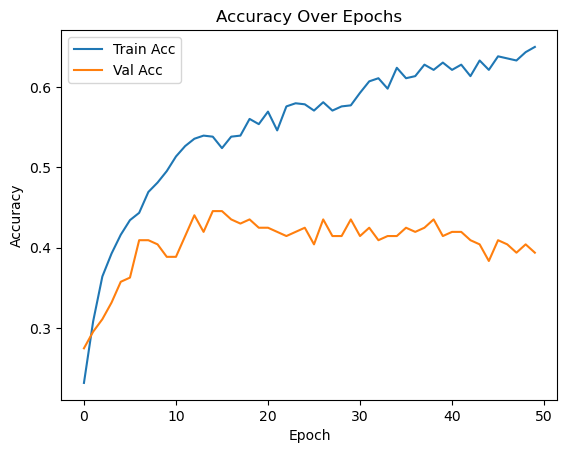

In [32]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [44]:
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

import pandas as pd
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
print(comparison_df.head(20))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
    Actual  Predicted
0        2          1
1        2          1
2        0          0
3        0          1
4        3          3
5        2          2
6        1          0
7        3          3
8        2          3
9        1          1
10       0          1
11       1          1
12       0          0
13       3          3
14       3          0
15       2          1
16       1          2
17       2          0
18       0          1
19       1          1


Instead of a neural network, try a simpler standard logistic regression model

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(
    multi_class='multinomial',  # for multiple classes
    max_iter=1000,             # increase iterations if needed
    random_state=42            # for reproducibility
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.56      0.56      0.56        79
           1       0.30      0.24      0.27        49
           2       0.31      0.33      0.32        57
           3       0.55      0.59      0.57        56

    accuracy                           0.45       241
   macro avg       0.43      0.43      0.43       241
weighted avg       0.44      0.45      0.45       241



C:\Users\rober\PycharmProjects\CedarPointMLModel\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Show Feature Importance


Top 15 Most Important Features:
                       feature  importance
9                 day_Saturday    1.012032
32                   week_18.0    0.705209
2    special_day_coaster_mania    0.648102
4      special_day_fathers_day    0.648059
34                   week_20.0    0.634182
5      special_day_mothers_day    0.595124
15                    week_1.0    0.591390
33                   week_19.0    0.556162
11                day_Thursday    0.532602
45         temperature_VeryHot    0.503956
1    special_day_halloweekends    0.478802
28                   week_14.0    0.473892
39                   week_25.0    0.452801
30                   week_16.0    0.428425
6   special_day_fourth_of_july    0.425995


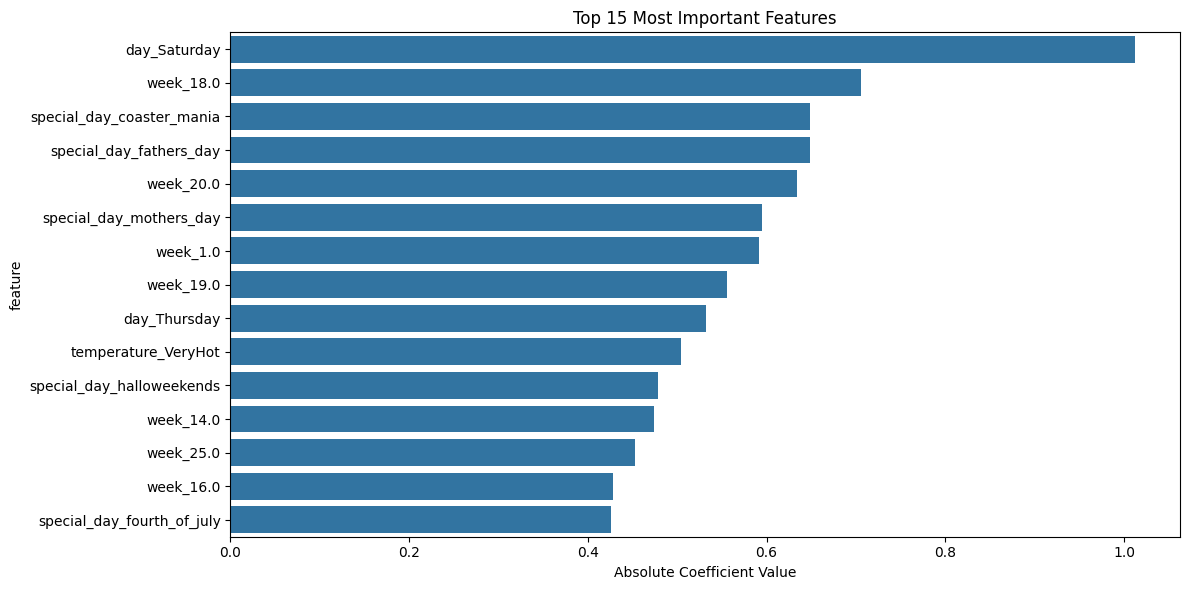

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(model.coef_).mean(axis=0)
})

# Sort and display top features
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()


Introduce polynomial features to see if it helps.

In [47]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial and interaction features
# degree=2 means it will create:
# - original features
# - squared terms (X²)
# - interaction terms (X1*X2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_train)

# Create new feature names for interpretation
feature_names = poly.get_feature_names_out(X_train.columns)

# Create new logistic regression with the polynomial features
model_poly = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
model_poly.fit(X_poly, y_train)

# Transform test storage the same way
X_test_poly = poly.transform(X_test)

# Make predictions
y_pred_poly = model_poly.predict(X_test_poly)

# Print performance metrics
print("\nClassification Report with Polynomial Features:")
print(classification_report(y_test, y_pred_poly))



Classification Report with Polynomial Features:
              precision    recall  f1-score   support

           0       0.54      0.43      0.48        79
           1       0.24      0.29      0.26        49
           2       0.31      0.33      0.32        57
           3       0.58      0.59      0.58        56

    accuracy                           0.41       241
   macro avg       0.42      0.41      0.41       241
weighted avg       0.43      0.41      0.42       241



C:\Users\rober\PycharmProjects\CedarPointMLModel\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


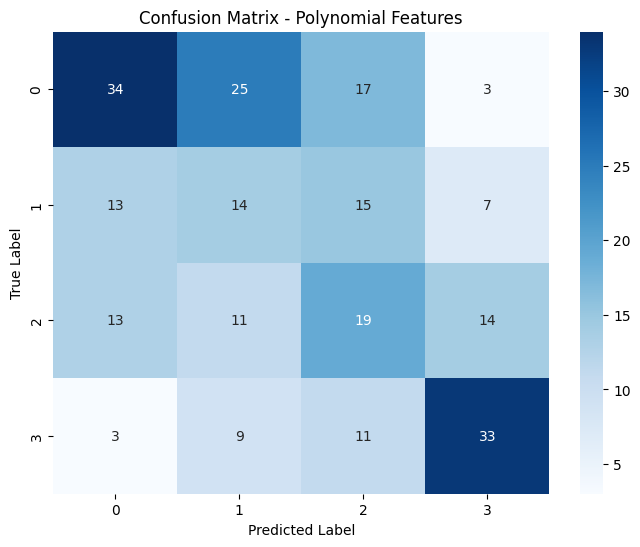


Top 15 Most Important Features:
                       feature  importance
508      day_Saturday week_9.0    0.666132
506      day_Saturday week_7.0    0.634758
673     day_Wednesday week_8.0    0.616756
1155      week_13.0 rain_Light    0.605160
590      day_Thursday week_6.0    0.600447
62     school_day day_Saturday    0.593603
457        day_Monday week_2.0    0.588085
1157       week_13.0 rain_None    0.582674
411        day_Friday week_1.0    0.559034
1329       week_21.0 rain_None    0.554079
699   day_Wednesday rain_Heavy    0.547304
630       day_Tuesday week_5.0    0.540134
598     day_Thursday week_14.0    0.538025
545        day_Sunday week_3.0    0.537379
460        day_Monday week_5.0    0.536950


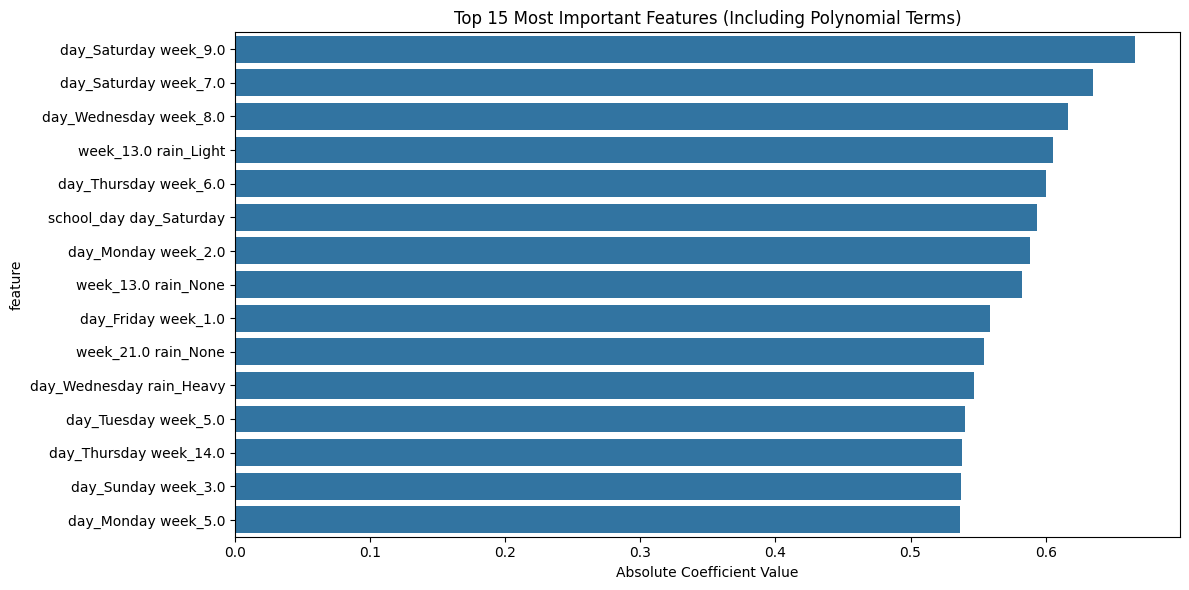

In [48]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Polynomial Features')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get feature names and importance
feature_names = poly.get_feature_names_out(X_train.columns)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(model_poly.coef_).mean(axis=0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Show top 15 most important features
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize top features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features (Including Polynomial Terms)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()


Try a decision tree.


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.68      0.57        79
           1       0.36      0.18      0.24        49
           2       0.39      0.42      0.40        57
           3       0.71      0.54      0.61        56

    accuracy                           0.49       241
   macro avg       0.49      0.46      0.46       241
weighted avg       0.49      0.49      0.47       241



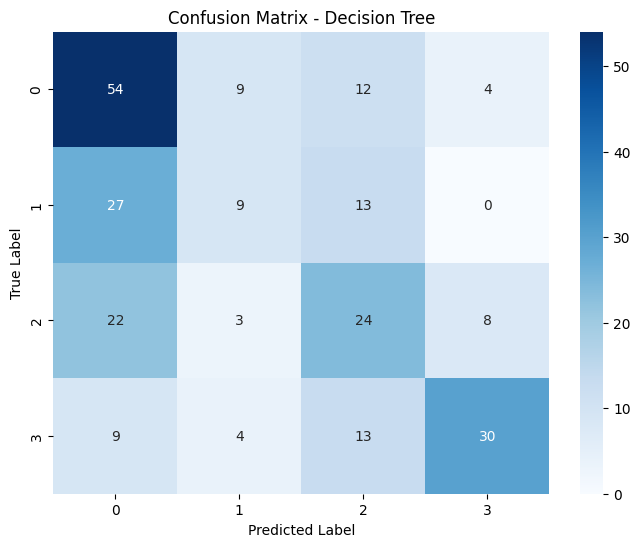


Top 10 Most Important Features:
            feature  importance
9      day_Saturday    0.382869
0        school_day    0.089832
43  temperature_Hot    0.078491
15         week_1.0    0.051024
8        day_Monday    0.039372
48       rain_Heavy    0.034966
32        week_18.0    0.030182
7        day_Friday    0.029537
10       day_Sunday    0.029220
20         week_6.0    0.028779


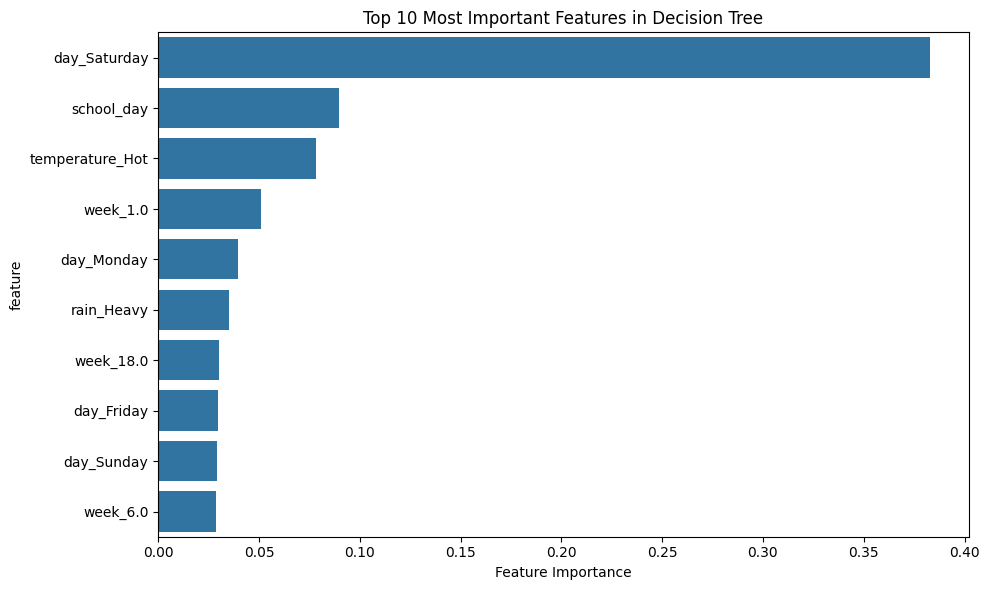

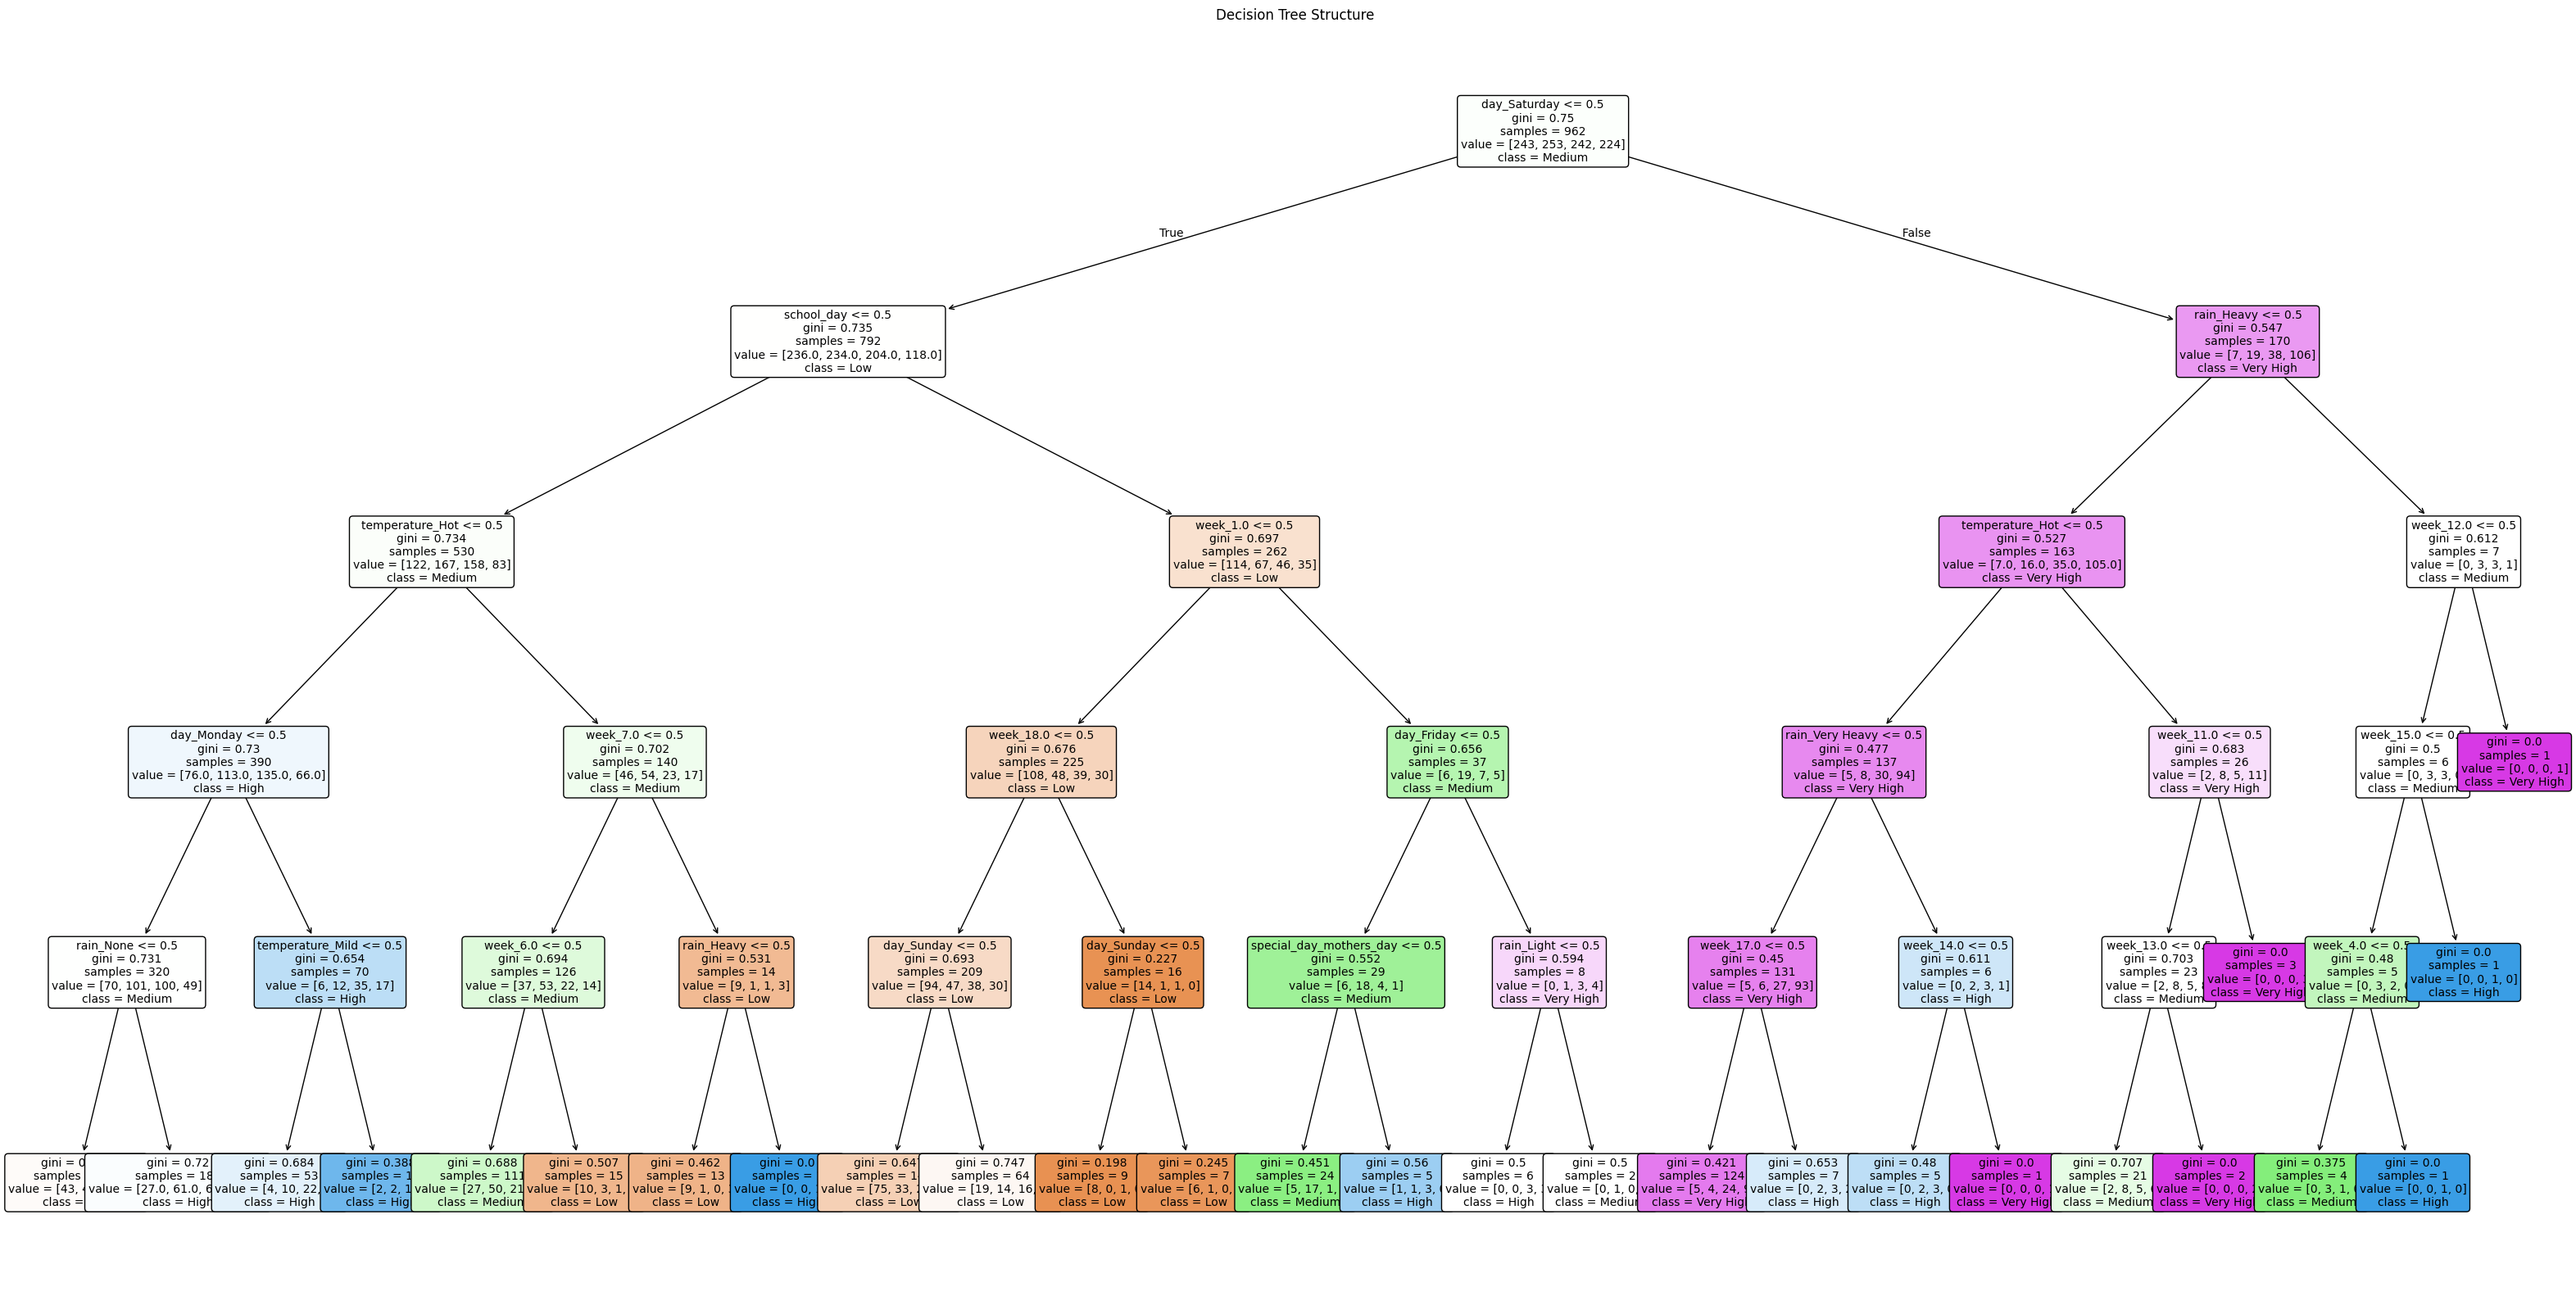

In [50]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Create and train the decision tree
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=5  # Limit depth to make it more interpretable
)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Print performance metrics
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Show top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features in Decision Tree')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Visualize the decision tree (limited to first few levels for clarity)
plt.figure(figsize=(40,20))
plot_tree(dt_model,
          feature_names=X_train.columns,
          class_names=['Low', 'Medium', 'High', 'Very High'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=8)  # Show only first 3 levels
plt.title('Decision Tree Structure')
plt.show()


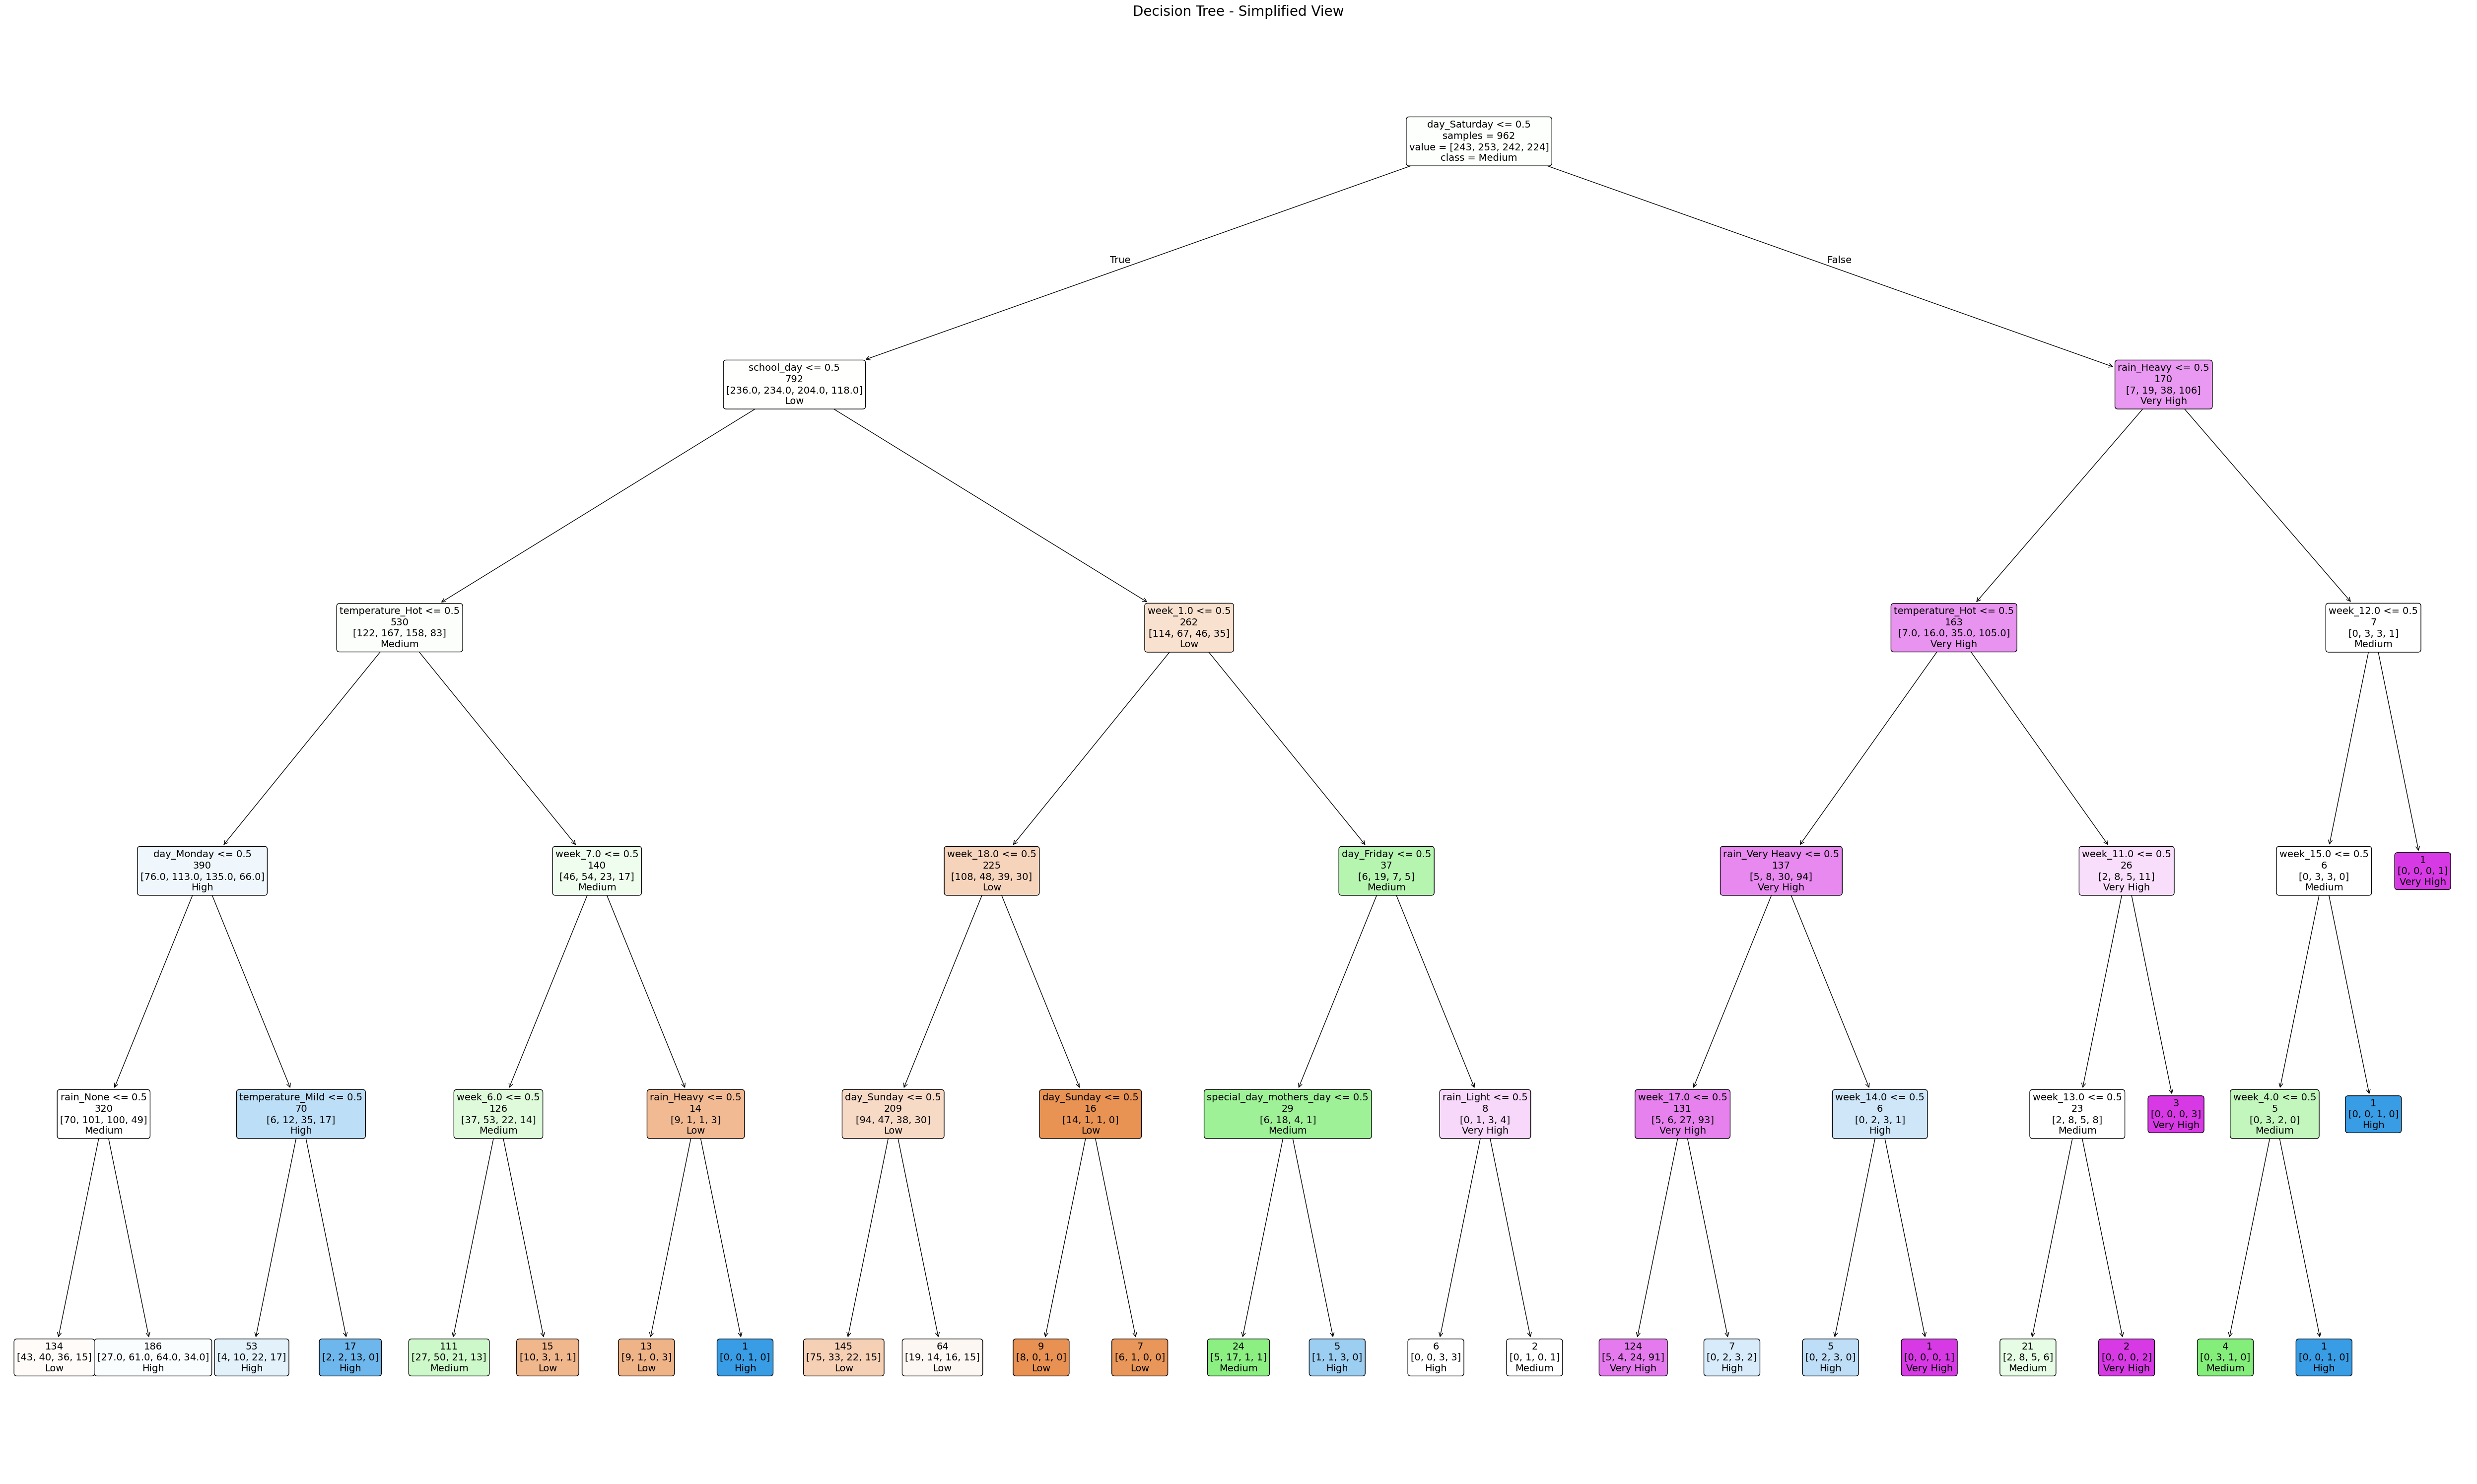

In [47]:
plt.figure(figsize=(50,30))  # Much larger figure size
plot_tree(dt_model,
          feature_names=X_train.columns,
          class_names=['Low', 'Medium', 'High', 'Very High'],
          filled=True,
          rounded=True,
          fontsize=14,      # Larger font size
          max_depth=None,
          impurity=False,
          proportion=False,
          precision=2,
          node_ids=False,
          label='root')
plt.title('Decision Tree - Simplified View', fontsize=20)
plt.tight_layout()  # This helps ensure everything fits
plt.show()

Random Forest MAE: 0.83
Random Forest MSE: 1.06


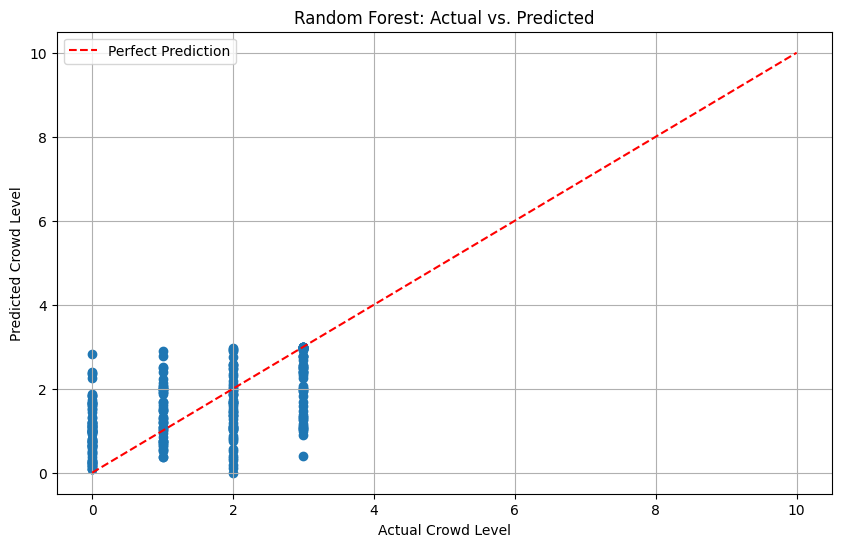

In [52]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the random forest model
rf_model = RandomForestRegressor(
    n_estimators=100,  # number of trees in the forest
    max_depth=None,    # maximum depth of the trees
    random_state=42    # for reproducibility
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest MSE: {rf_mse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_preds)
plt.xlabel("Actual Crowd Level")
plt.ylabel("Predicted Crowd Level")
plt.title("Random Forest: Actual vs. Predicted")
plt.grid(True)
plt.plot([0, 10], [0, 10], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()

